# notes

When the number the time-point in the basis is low (1000) then the random draws doesn't show too many strange features.
But we might need more time-points so that when we interpolate the amplitude and phase the match is high.

When the number of time-points is too high, then the amp and phase predictions can have larger variations and cause strange features.
This means that even though the mean match is good, the random draws can be terrible.

To fix this we could, instead of sampling randomly from each parameter, join the parameters together via a hyperparameter s(theta).
Such that s(theta=0) = y_min and s(theta=1) = y_max?

In [44]:
# average model (the average might not be along the path between models, only true for n-models > 2)
# vector from average to other models


# or
# pick a model
# pick another model
# pick distance along vector between those two
# - so this produces a blending/interpolation of any two models
# - this method doesn't depend on the ROM/Surrogate method


# v2 and PhenD at high spin. - or at high mass-ratio for example mass-ratio 30? keep it non-spinning.
# do a PE for one of these cases to make sure that the PE results have an issue we can solve.
# - try blending the two models
# - try ROM
#   - random coeffs
#   - travelling bewtween along vectors

In [77]:
# matches of models vs models - what is their variation?

# check that the uber model can actually recover the models - project the models onto the uber basis and check.

# maybe draw about mean with Gaussian instead of uniform(ymin, ymax)

# check if there is a hierachy to EIM basis

In [ ]:
# i was trying to check that the basis can reproduce the training set waveforms
# but the accuracy is much less than i would expect.
# I have a suspicion that the EIM basis is not working and so should check by trying the reduced-basis coeffs and basis functions.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
matplotlib.rcParams.update({'font.size': 16})

import numpy as np
import os
import glob
import copy

In [2]:
from scrinet.interfaces import lalutils

import lal
import lalsimulation as lalsim

import utils

import rompy as rp

from scrinet.greedy import greedyrb

In [3]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [4]:
import phenom

In [5]:
import glob
import os

In [6]:
default_cycle_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
print(default_cycle_colors)

from cycler import cycler

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


# helpers

In [7]:
def y22_func(theta, phi):
    """
    https://lscsoft.docs.ligo.org/lalsuite/lal/_spherical_harmonics_8c_source.html#l00042
    """
    fac = np.sqrt(5.0 / (64.0 * lal.PI)) * \
        (1.0 + np.cos(theta))*(1.0 + np.cos(theta))

    m = 2.
    return np.exp(1.j * m * phi) * fac

# @tf.function


def y2m2_func(theta, phi):
    """
    https://lscsoft.docs.ligo.org/lalsuite/lal/_spherical_harmonics_8c_source.html#l00042
    """
    fac = np.sqrt(5.0 / (64.0 * lal.PI)) * \
        (1.0 - np.cos(theta))*(1.0 - np.cos(theta))

    m = -2.
    return np.exp(1.j * m * phi) * fac

In [8]:
def interpolate_list(x, ys):
    """
    x : array of mass-ratios
    ys: list of arrays for each eim coefficient
    """
    iy=[]
    for y in ys:
        iy.append(IUS(x, y))
    return iy

In [9]:
def load_model(model_name):
    
    # basis
    B = np.load(os.path.join(model_name, "eim_basis.npy"))
    # eim indicies
    indices = np.load(os.path.join(model_name, "eim_indices.npy"))

    # load mean, min and max

    x_dense = np.load(os.path.join(model_name, "x.npy"))
    y_mean = np.load(os.path.join(model_name, "ymean.npy"))
    y_min = np.load(os.path.join(model_name, "ymin.npy"))
    y_max = np.load(os.path.join(model_name, "ymax.npy"))
    
    times = np.load(os.path.join(model_name, "times.npy"))
    
    return B, indices, x_dense, y_mean, y_min, y_max, times

In [10]:
def get_random_coeff(q, iy_mins, iy_maxs):
    num = len(iy_mins)
    
    ymins = [iy_min(q) for iy_min in iy_mins]
    ymaxs = [iy_max(q) for iy_max in iy_maxs]
    
    alphas = [np.random.uniform(ymins[i], ymaxs[i]) for i in range(num)]
    
    return np.asarray(alphas)

In [11]:
def get_mean_coeff(q, iy_means):
    num = len(iy_means)
    ymeans = [iy_mean(q) for iy_mean in iy_means]
    
    return np.asarray(ymeans)

In [12]:
def predict(alpha, B):
    return np.dot(alpha, B)

In [13]:
class model(object):
    def __init__(self, model_name):
        self.model_name = model_name
        
        self.B, self.indices, self.x_dense, self.y_mean, self.y_min, self.y_max, self.times = load_model(self.model_name)
        
        self.size = self.B.shape[0]
        
        self.iy_means = interpolate_list(self.x_dense, self.y_mean)
        self.iy_mins = interpolate_list(self.x_dense, self.y_min)
        self.iy_maxs = interpolate_list(self.x_dense, self.y_max)
        
    def predict(self, alpha):
        return np.dot(alpha, self.B)
    
    def get_mean_coeff(self, q):
        num = len(self.iy_means)
        ymeans = [iy_mean(q) for iy_mean in self.iy_means]

        return np.asarray(ymeans)

    def get_random_coeff(self, q):
        num = len(self.iy_mins)

        
        ymins = [iy_min(q) for iy_min in self.iy_mins]
        ymaxs = [iy_max(q) for iy_max in self.iy_maxs]

#         alphas = [np.random.uniform(ymins[i], ymaxs[i]) for i in range(num)]

        ymeans = [iy_mean(q) for iy_mean in self.iy_means]
        alphas = [np.random.normal(ymeans[i], (ymaxs[i]-ymins[i])/10) for i in range(num)]

        return np.asarray(alphas)
    
    def get_mean_min_max(self, q):
        num = len(self.iy_means)
        ymeans = [iy_mean(q) for iy_mean in self.iy_means]
        ymins = [iy_min(q) for iy_min in self.iy_mins]
        ymaxs = [iy_max(q) for iy_max in self.iy_maxs]        
        
        return np.asarray(ymeans), np.asarray(ymins), np.asarray(ymaxs)

In [14]:
class UberModel(object):
    def __init__(self, amp_model, phase_model):
        self.amp_model = amp_model
        self.phase_model = phase_model
        
        self.times = self.amp_model.times
        
    def predict_from_projection(self, amp_alpha, phase_alpha):
        """
        provide arrays for amp and phase EIM coefficients exactly
        """
        
        
        self.amp = self.amp_model.predict(amp_alpha)
        self.phase = self.phase_model.predict(phase_alpha)
        
        self.h = self.amp * np.exp(-1.j * self.phase)
        
        
    def predict_mean(self, q):
        
        amp_alpha = self.amp_model.get_mean_coeff(q)
        phase_alpha = self.phase_model.get_mean_coeff(q)
        
        self.amp = self.amp_model.predict(amp_alpha)
        self.phase = self.phase_model.predict(phase_alpha)
        
        self.h = self.amp * np.exp(-1.j * self.phase)
        
    def predict_random(self, q, num_draws):
        self.num_draws = num_draws
        
        amp_alphas = [self.amp_model.get_random_coeff(q) for n in range(num_draws)]
        phase_alphas = [self.phase_model.get_random_coeff(q) for n in range(num_draws)]
        
        self.amp_draws = np.asarray([self.amp_model.predict(amp_alpha) for amp_alpha in amp_alphas])
        self.phase_draws = np.asarray([self.phase_model.predict(phase_alpha) for phase_alpha in phase_alphas])
        
        self.h_draws = self.amp_draws * np.exp(-1.j * self.phase_draws)
        
    def predict_hp_hc(self, q, mtot, dist, dt, theta=0, phi=0, predict_type='mean', amp_alpha=None, phase_alpha=None):
        """
        q: mass-ratio
        mtot: total mass in Msun
        dist: distance to source in metres
        dt: dt in seconds (1/sample_rate)
        theta, phi: direction of propogation (sph. harm. coordinates)
        
        predict_type='from_projection' then specify: amp_alpha=None, phase_alpha=None
        """
        self.dt = dt
        times_sec = phenom.MtoS(self.times, mtot)
        self.times_sec = np.arange(times_sec[0], times_sec[-1], self.dt)
        
        if predict_type == 'mean':
            self.predict_mean(q)
        elif predict_type == 'from_projection':
            self.predict_from_projection(amp_alpha, phase_alpha)
        else:
            raise(ValueError('unknown predict_type'))
        
        amp_pre_fac = lalutils.td_amp_scale(mtot, dist)
        
        self.amp = self.amp * amp_pre_fac
        
        amp = IUS(times_sec, self.amp)(self.times_sec)
        phase = IUS(times_sec, self.phase)(self.times_sec)
        
        h = amp * np.exp(-1.j * phase)
        
        y22 = y22_func(theta, phi)
        y2m2 = y2m2_func(theta, phi)

        h_complex = h*y22 + np.conj(h)*y2m2

        self.hplus = np.real(h_complex)
        self.hcross = np.imag(h_complex)

    def predict_random_hp_hc(self, num_draws, q, mtot, dist, dt, theta=0, phi=0):
        """
        q: mass-ratio
        mtot: total mass in Msun
        dist: distance to source in metres
        dt: dt in seconds (1/sample_rate)
        theta, phi: direction of propogation (sph. harm. coordinates)
        """
        self.dt = dt
        times_sec = phenom.MtoS(self.times, mtot)
        self.times_sec = np.arange(times_sec[0], times_sec[-1], self.dt)
        
        self.predict_random(q, num_draws)
        
        amp_pre_fac = lalutils.td_amp_scale(mtot, dist)
        
        self.amp_draws = self.amp_draws * amp_pre_fac
        
        amp_draws = [IUS(times_sec, amp)(self.times_sec) for amp in self.amp_draws]
        amp_draws = np.asarray(amp_draws)
        phase_draws = [IUS(times_sec, phase)(self.times_sec) for phase in self.phase_draws]
        phase_draws = np.asarray(phase_draws)
        
        h = amp_draws * np.exp(-1.j * phase_draws)
        
        y22 = y22_func(theta, phi)
        y2m2 = y2m2_func(theta, phi)

        h_complex = h*y22 + np.conj(h)*y2m2

        self.hplus_draws = np.real(h_complex)
        self.hcross_draws = np.imag(h_complex)

# load models

In [15]:
# amp_model = model("amp_210212_gjejch3f")
# amp_model = model("amp_210217_zerp2sdj")


# tol 1e-5 and npts = 10000
# amp_model = model("amp_210217_4tlwzk1b")

# tol 1e-5 and npts = 1000
# amp_model = model("amp_210217_cchgzggn")

# tol 1e-10 and npts = 10000
# amp_model = model("amp_210217_c_t3po9p")



# only eob
# amp_model = model("amp_210217_wd3u77sc")


# only eob, tol 1e-16, npts = 1000, t_max = 75
amp_model = model("amp_210218_z0bg1vnq")

# same as above but no peak alignment
# amp_model = model("amp_210218_ox4pes1c")


# fewer models
# amp_model = model("amp_210217_4lgxa7tz")

# amp_model = model("amp_210218_151giljm")

In [16]:
# phase_model = model("phase_210212_9kkqpm5s")
# phase_model = model("phase_210217_ill1mjyi")


# tol 1e-5 and npts = 10000
# phase_model = model("phase_210217_6e2wjkxq")

# tol 1e-5 and npts = 1000
# phase_model = model("phase_210217_hx_d6ml8")

# tol 1e-10 and npts = 10000
# phase_model = model("phase_210217_v3caanvk")


# only eob
# phase_model = model("phase_210217_k6nvi_ft")

# only eob, tol 1e-16, npts = 1000, t_max = 75
phase_model = model("phase_210218_jjc9ww72")
# same as above but no peak alignment
# phase_model = model("phase_210218_7fhho7jv")



# fewer models
# phase_model = model("phase_210217_d2b6_hq3")


# phase_model = model("phase_210218_k69uc2d6")

In [17]:
# freq_model = model("freq_210212_udub3g1t")
# # freq_model = model("freq_210217_zxmbhxrr")

In [18]:
amp_model.model_name

'amp_210218_z0bg1vnq'

In [19]:
amp_model.get_mean_coeff(1).size

75

In [20]:
phase_model.get_mean_coeff(1).size

40

In [21]:
amp_model.get_mean_coeff(1)

array([0.39440301, 0.15039867, 0.18012842, 0.27364846, 0.35959013,
       0.34055908, 0.11355574, 0.39152694, 0.04581062, 0.38862538,
       0.38242229, 0.39300606, 0.32497453, 0.20339301, 0.20025481,
       0.35200814, 0.19736341, 0.31013398, 0.19033516, 0.24963049,
       0.20682435, 0.38229711, 0.34470813, 0.19367383, 0.36530569,
       0.36733117, 0.37501764, 0.18647267, 0.22252642, 0.18054604,
       0.20611239, 0.20754941, 0.33775507, 0.18337641, 0.22946053,
       0.24267478, 0.27666203, 0.33117547, 0.16507166, 0.17582674,
       0.17825693, 0.30851651, 0.31914314, 0.18856354, 0.21566557,
       0.17146725, 0.21009746, 0.2021057 , 0.31366419, 0.20472695,
       0.19468909, 0.16949822, 0.20541252, 0.15947001, 0.28337855,
       0.18488882, 0.19849234, 0.12988465, 0.15324307, 0.1623235 ,
       0.19172705, 0.17384438, 0.13515937, 0.29484294, 0.15449669,
       0.15334372, 0.22471448, 0.10962587, 0.19626921, 0.14908047,
       0.13154508, 0.16742519, 0.14004751, 0.15671961, 0.30367

In [22]:
amp_model.times.shape

(1000,)

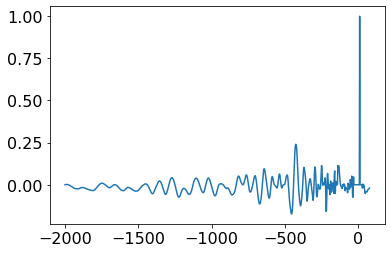

In [29]:
plt.figure()
plt.plot(amp_model.times, amp_model.B[5])

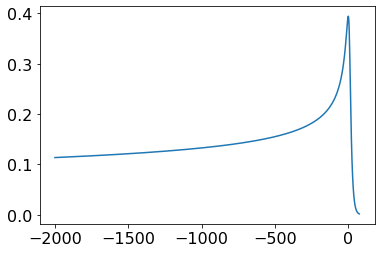

In [30]:
plt.figure()
plt.plot(amp_model.times, amp_model.predict(amp_model.get_mean_coeff(1)))

In [31]:
uber = UberModel(amp_model, phase_model)

In [32]:
uber.predict_mean(15)

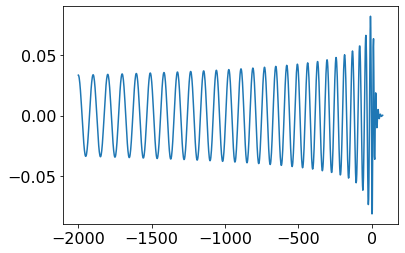

In [33]:
plt.figure()
plt.plot(uber.times, uber.h.real)

In [34]:
uber.predict_random(15, 100)

In [35]:
uber.amp_draws.shape

(100, 1000)

In [36]:
uber.h_draws.shape

(100, 1000)

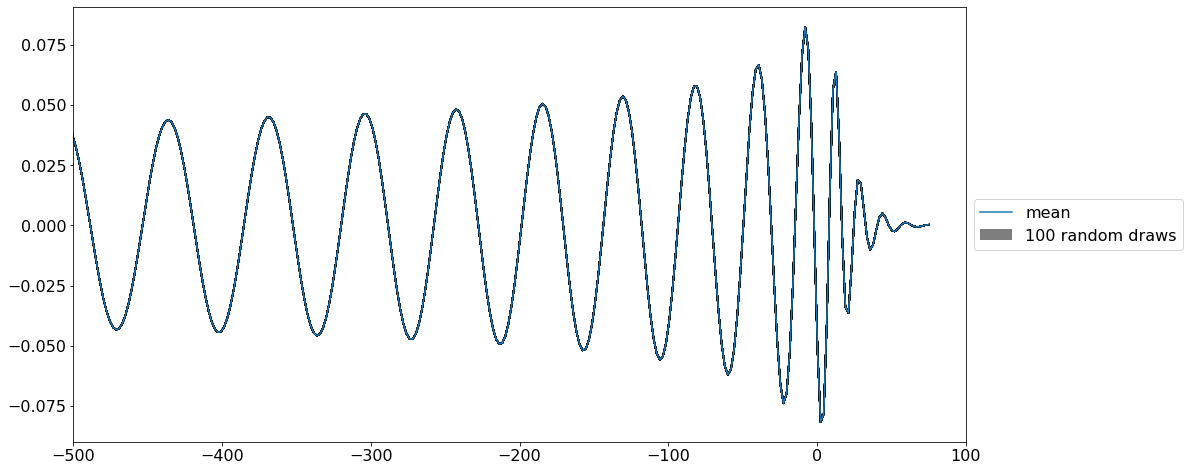

In [37]:
plt.figure(figsize=(16, 8))
for h in uber.h_draws:
    plt.plot(uber.times, h.real, c='k', alpha=0.3)
l1 = plt.plot(uber.times, uber.h.real, label='mean')
plt.xlim(-500, 100)
# plt.xlim(-100, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

patch = Patch(facecolor='k', alpha=0.5, label=f'{uber.num_draws} random draws')
plt.legend(handles=[l1[0], patch], loc='center left', bbox_to_anchor=(1, 0.5))

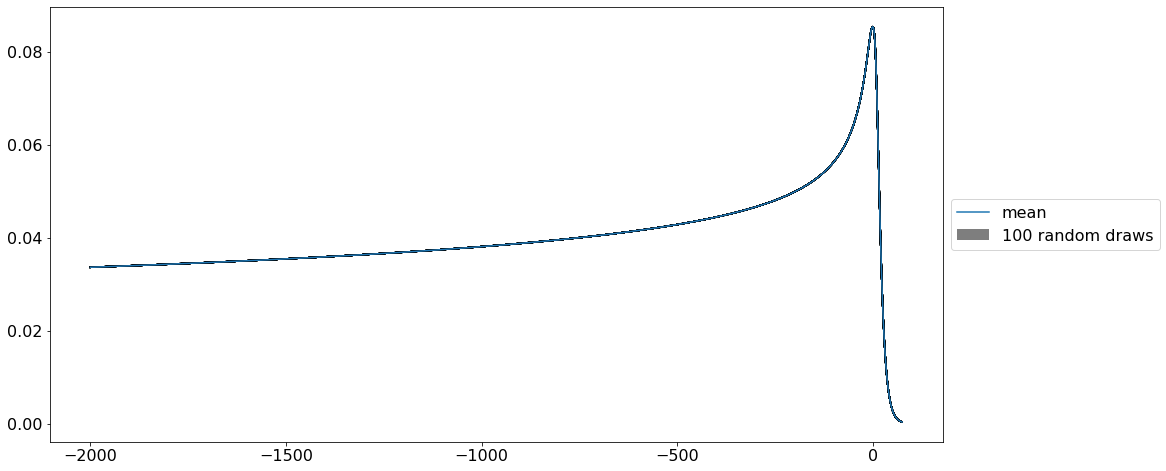

In [38]:
plt.figure(figsize=(16, 8))
for amp in uber.amp_draws:
    plt.plot(uber.times, amp, c='k', alpha=0.3)
l1 = plt.plot(uber.times, uber.amp, label='mean')
# plt.xlim(-500, 100)
# plt.xlim(-100, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

patch = Patch(facecolor='k', alpha=0.5, label=f'{uber.num_draws} random draws')
plt.legend(handles=[l1[0], patch], loc='center left', bbox_to_anchor=(1, 0.5))

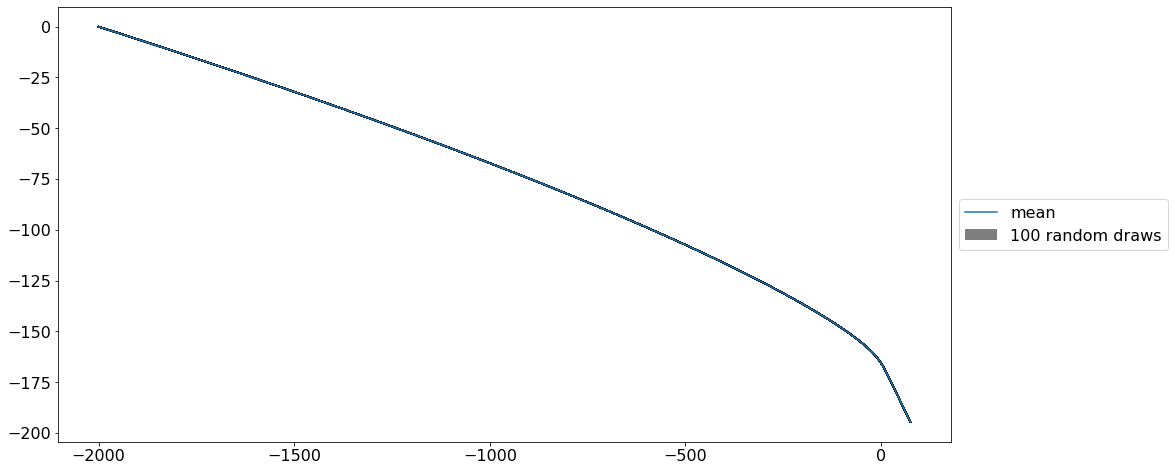

In [39]:
plt.figure(figsize=(16, 8))
for phase in uber.phase_draws:
    plt.plot(uber.times, phase, c='k', alpha=0.3)
l1 = plt.plot(uber.times, uber.phase, label='mean')
# plt.xlim(-500, 100)
# plt.xlim(-100, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

patch = Patch(facecolor='k', alpha=0.5, label=f'{uber.num_draws} random draws')
plt.legend(handles=[l1[0], patch], loc='center left', bbox_to_anchor=(1, 0.5))

# widget

In [40]:
ymeans, ymins, ymaxs = amp_model.get_mean_min_max(18)

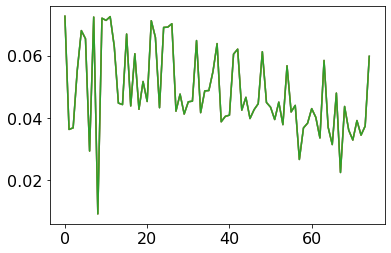

In [41]:
plt.figure()
plt.plot(ymeans)
plt.plot(ymins)
plt.plot(ymaxs)

(-100, 100)

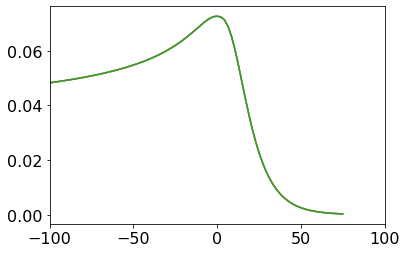

In [42]:
plt.figure()
plt.plot(amp_model.times, amp_model.predict(ymeans))
plt.plot(amp_model.times, amp_model.predict(ymins))
plt.plot(amp_model.times, amp_model.predict(ymaxs))
plt.xlim(-100, 100)

In [43]:
blended = lambda a: amp_model.predict(ymins) * a + (1-a)*amp_model.predict(ymaxs)

(-200, 100)

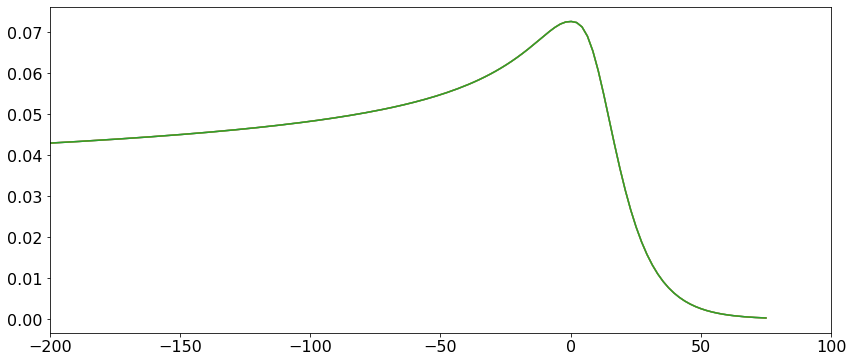

In [45]:
# make this with phenom C

plt.figure(figsize=(14, 6))
plt.plot(amp_model.times, blended(0))

plt.plot(amp_model.times, blended(0.5))

plt.plot(amp_model.times, blended(1))

# plt.plot(amp_model.times, amp_model.predict(ymins))
plt.xlim(-200, 100)
# plt.yscale('log')

(-100, 100)

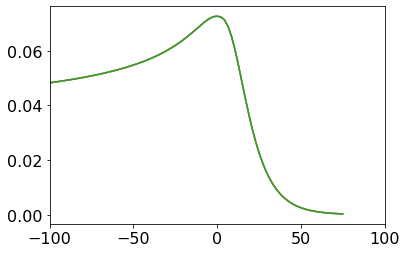

In [46]:
plt.figure()
plt.plot(amp_model.times, amp_model.predict(ymeans))
plt.plot(amp_model.times, amp_model.predict(ymins))
plt.plot(amp_model.times, amp_model.predict(ymaxs))
plt.xlim(-100, 100)

In [47]:
ymins.shape

(75,)

In [48]:
ymins[0]

0.07261862026780727

In [49]:
ymaxs[0]

0.07261862026780727

In [50]:
amp_model.size

75

In [44]:
amp_model.size

18

In [45]:
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

# def f(alpha0, alpha1, alpha2, alpha3, alpha4,
#      alpha5, alpha6, alpha7, alpha8, alpha9,
#      alpha10, alpha11, alpha12, alpha13, alpha14,
#      alpha15, alpha16, alpha17, alpha18, alpha19,
#      alpha20, alpha21):
def f(alpha0, alpha1, alpha2, alpha3, alpha4,
     alpha5, alpha6):
    
    # get the names of the input arguments
    inputs = list(locals().keys())
    
#     print(locals())
    
#     print(locals()['alpha0'])
    
    plt.figure(figsize=(14, 8))
    plt.plot(amp_model.times, amp_model.predict(ymeans), label='mean')
    
    ymeans_mod = ymeans.copy()
    
    for i in range(len(inputs)):
        k = inputs[i]
        ymeans_mod[i] = locals()[k]
       
    yhat = amp_model.predict(ymeans_mod)
    plt.plot(amp_model.times, yhat, label='mod')
    
    x = amp_model.times[amp_model.indices]
    y = yhat[amp_model.indices]
    plt.plot(x, y, 'o')
    
    plt.xlim(-500, 100)
    plt.ylim(0, 0.08)
    plt.show()


# kwargs = {f'alpha{i}': (ymins[i], ymaxs[i], (ymaxs[i] - ymins[i])/10.) for i in range(amp_model.size)}
# kwargs = {f'alpha{i}': (ymins[i], ymaxs[i], (ymaxs[i] - ymins[i])/10.) for i in range(3)}
kwargs = {f'alpha{i}': (ymins[i], ymaxs[i], (ymaxs[i] - ymins[i])/10.) for i in range(7)}
    
interactive_plot = interactive(f, **kwargs)
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

ValueError: step must be >= 0, not 0.0

# compare with other models

In [46]:
def get_waveform_model_data(approx, q, npts):
    lal_approx = lalsim.GetApproximantFromString(approx)
    return utils.WaveformGeneration(approximant=lal_approx, q=q, npts=npts)

In [47]:
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", 'IMRPhenomT', 'IMRPhenomXAS']
approxs = ["SEOBNRv4_opt", "IMRPhenomD", 'IMRPhenomT', 'IMRPhenomXAS']
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "SEOBNRv4", 'IMRPhenomT', 'IMRPhenomC']

In [48]:
def compare_with_models(q, approxs):
    npts = 1000
    wfs = [get_waveform_model_data(approx, q, npts) for approx in approxs]
    

    uber = UberModel(amp_model, phase_model)
    uber.predict_mean(q)
    
    n_draws = 100
    uber.predict_random(q, n_draws)

    plt.figure(figsize=(14, 8))    
    for h in uber.h_draws:
        plt.plot(uber.times, h.real, c='k', alpha=0.2)
    l1 = plt.plot(uber.times, uber.h.real, label='mean')

    patch = Patch(facecolor='k', alpha=0.2, label=f'{uber.num_draws} random draws')

    plt.plot(uber.times, uber.h.real, label='uber mean')
    
    lls = []
    for wf in wfs:
        lls.append(plt.plot(wf.times, wf.Reh22, label=wf.label)[0])
        
    plt.xlim(-400, 100)
    plt.legend(handles=[l1[0], patch] + lls, loc='center left', bbox_to_anchor=(1, 0.5))

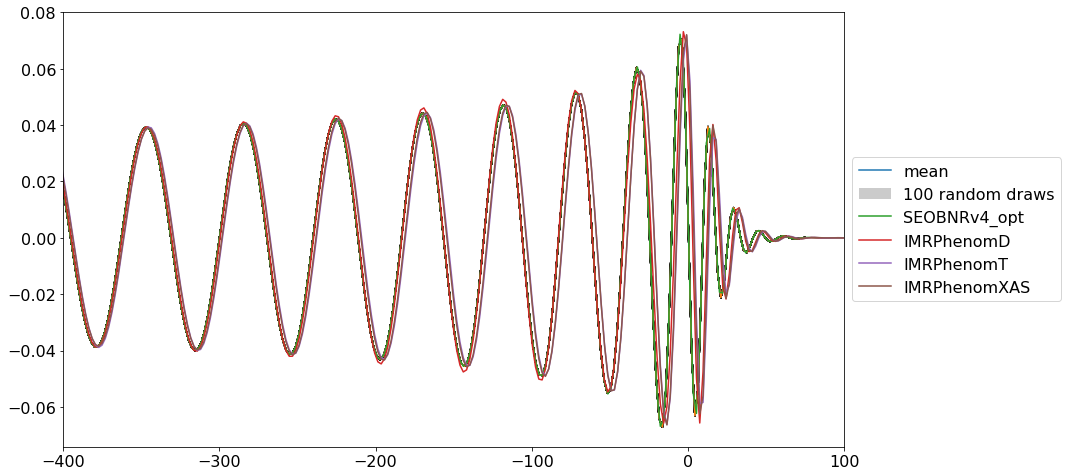

In [49]:
compare_with_models(18, approxs)

# computing the match

## mean prediction hp

In [50]:
q = 1
mtot = 100
dt = 1./2048/2
uber = UberModel(amp_model, phase_model)
uber.predict_mean(q)

In [51]:
uber.predict_hp_hc(q, mtot, 1e6*lal.PC_SI, dt)

In [52]:
uber.hplus

array([3.42907952e-19, 3.42852450e-19, 3.42647470e-19, ...,
       2.00648846e-21, 2.72334133e-21, 3.18207569e-21])

In [53]:
1/(uber.times_sec[1]-uber.times_sec[0])

4096.0

In [54]:
1/uber.dt

4096.0

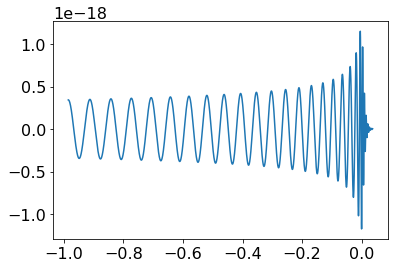

In [55]:
plt.figure()
plt.plot(uber.times_sec, uber.hplus)

In [56]:
import pycbc.waveform
import pycbc.types
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

In [57]:
m1, m2 = phenom.m1_m2_M_q(mtot, q)

In [58]:
uber_ts = pycbc.types.TimeSeries(uber.hplus, delta_t=uber.dt, epoch=uber.times_sec[0])

In [59]:
hp, hc = pycbc.waveform.get_td_waveform(approximant='SEOBNRv4', mass1=m1, mass2=m2, f_lower=21, delta_t=dt)

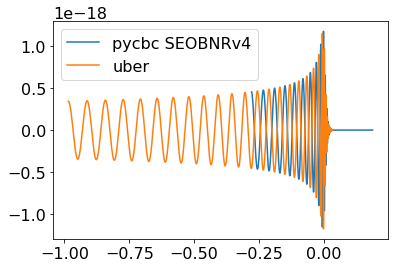

In [60]:
plt.figure()
plt.plot(hp.sample_times, hp, label='pycbc SEOBNRv4')
plt.plot(uber_ts.sample_times, uber_ts, label='uber')
plt.legend()
# plt.xlim(-0.1, 0.1)

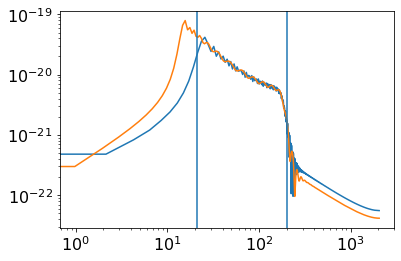

In [61]:
hp_fs = hp.to_frequencyseries()
uber_fs = uber_ts.to_frequencyseries()
plt.figure()
plt.plot(hp_fs.sample_frequencies, np.abs(hp_fs))
plt.plot(uber_fs.sample_frequencies, np.abs(uber_fs))
plt.axvline(21)
plt.axvline(200)
plt.yscale('log')
plt.xscale('log')

In [62]:
def compute_match(t1, t2, f_low, f_high=None, pad=None, psd=True):
    tlen = max(len(t1), len(t2))
    if pad:
        tlen = tlen*pad
    t1.resize(tlen)
    t2.resize(tlen)
    
    delta_f = 1./t1.duration
    flen = tlen//2 + 1
    if psd == True:
        psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    else:
        psd = None
    
    m, _ = match(t1, t2, psd=psd, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high)
    
    return m

In [63]:
compute_match(hp, uber_ts, 20, 200)

0.9840780140061086

## trying random draws hp

In [64]:
uber = UberModel(amp_model, phase_model)
n_draws = 100

uber.predict_hp_hc(q, mtot, 1e6*lal.PC_SI, dt)
uber.predict_random_hp_hc(n_draws, q, mtot, 1e6*lal.PC_SI, dt)

(-0.1, 0.04)

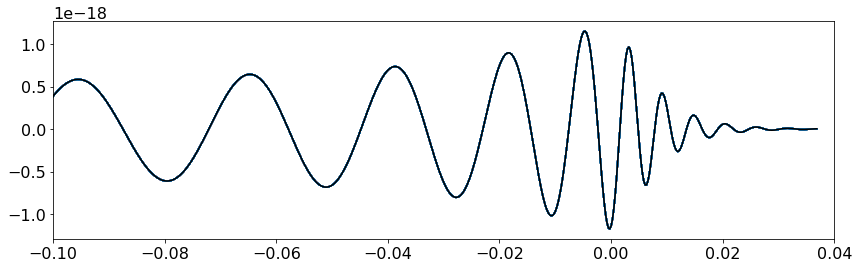

In [65]:
plt.figure(figsize=(14, 4))
for i in range(n_draws):
    plt.plot(uber.times_sec, uber.hplus_draws[i], c='C0', alpha=0.2)
plt.plot(uber.times_sec, uber.hplus, c='k')
plt.xlim(-0.1,0.04)

In [66]:
# convert to pycbc timeseries to use match code

In [67]:
uber_draws_ts = [pycbc.types.TimeSeries(uber.hplus_draws[i], delta_t=uber.dt, epoch=uber.times_sec[0]) for i in range(n_draws)]

In [68]:
matches = np.array([compute_match(hp, u, 30) for u in uber_draws_ts])

In [69]:
np.mean(matches)

0.9886063636110707

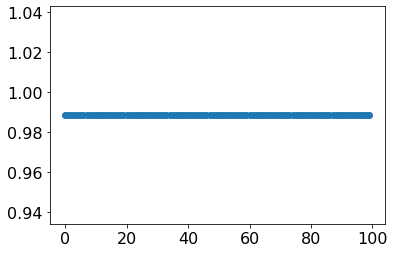

In [70]:
plt.figure()
plt.plot(range(n_draws), matches, 'o')

In [71]:
def compare_matches_with_models(approxs, q, mtot, n_draws, f_lower=12, delta_t=1/2048.):
    
    uber = UberModel(amp_model, phase_model)

    uber.predict_hp_hc(q, mtot, 1e6*lal.PC_SI, delta_t)
    uber.predict_random_hp_hc(n_draws, q, mtot, 1e6*lal.PC_SI, delta_t)
    
    uber_mean_ts = pycbc.types.TimeSeries(uber.hplus, delta_t=uber.dt, epoch=uber.times_sec[0])
    uber_draws_ts = [pycbc.types.TimeSeries(uber.hplus_draws[i], delta_t=uber.dt, epoch=uber.times_sec[0]) for i in range(n_draws)]
    
    hps = {}
    for approx in approxs:
        m1, m2 = phenom.m1_m2_M_q(mtot, q)
        hp, _ = pycbc.waveform.get_td_waveform(approximant=approx, mass1=m1, mass2=m2, f_lower=f_lower, delta_t=delta_t)
        hps.update({approx:hp})
        
    matches = {}
    for approx in approxs:
        matches.update({approx:np.array([compute_match(hps[approx], u, f_lower) for u in uber_draws_ts])})
        
    mean_matches = {}
    for approx in approxs:
        mean_matches.update({approx:compute_match(hps[approx], uber_mean_ts, f_lower)})
        
    return matches, mean_matches

In [72]:
approxs = ["SEOBNRv4_opt", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", 'IMRPhenomT', 'IMRPhenomXAS']

In [73]:
%%time
n_draws = 500
matches, mean_matches = compare_matches_with_models(approxs, 1, 100, n_draws, 20)

CPU times: user 54.7 s, sys: 816 ms, total: 55.5 s
Wall time: 8.02 s


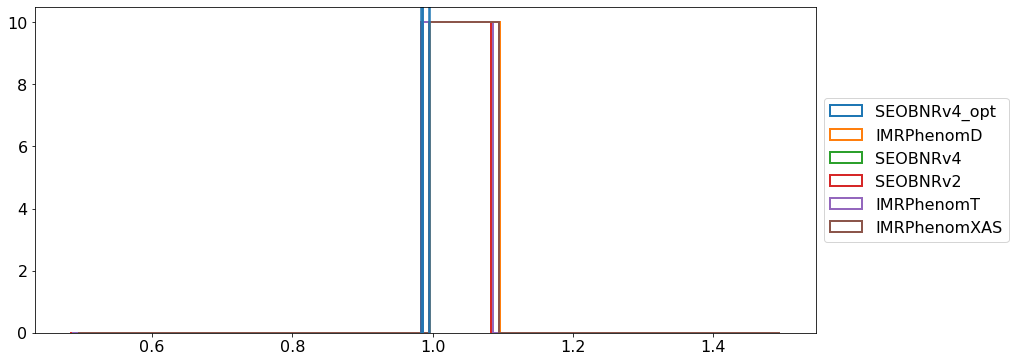

In [74]:
plt.figure(figsize=(14, 6))
for k, v in matches.items():
#     plt.plot(range(n_draws), v, '-o' , label=k)
    plt.hist(v, density=True, histtype='step', bins=10, lw=2, label=k)
    
for k, v in mean_matches.items():
    plt.axvline(v)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

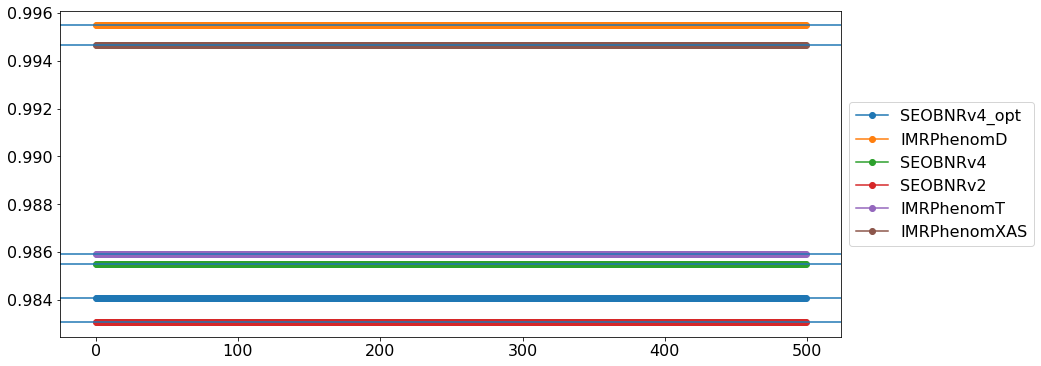

In [75]:
plt.figure(figsize=(14, 6))
for k, v in matches.items():
    plt.plot(range(n_draws), v, '-o' , label=k)
    
for k, v in mean_matches.items():
    plt.axhline(v)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [76]:
mean_matches

{'SEOBNRv4_opt': 0.9840632786418673,
 'IMRPhenomD': 0.9954739613779017,
 'SEOBNRv4': 0.9855022423901278,
 'SEOBNRv2': 0.983074286052232,
 'IMRPhenomT': 0.9859012764175976,
 'IMRPhenomXAS': 0.9946405627432893}

# check that the basis actual captures the models

# find NR waveforms

In [78]:
import glob
import os

In [79]:
# get data
nrfiles_single_res = dict(
    q1="/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5",
    q2="/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5",
    q4="/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5",
    q5="/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5",
    q10="/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5",
    q18="/Users/spx8sk/work/git/stk/ml/waveforms/bob/q18a0a0c025_144-22-hybrid.h5",
)

In [80]:
def make_nr_dict():
    """
    makes a dictionary of paths to NR files
    with multiple resolutions
    """
    root_dir = "/Users/spx8sk/work/data/"
    nr_ids = dict(q1="180", q2="169", q4="167", q5="107", q10="303")

    nrfiles = {}

    for key, val in nr_ids.items():
        ps = glob.glob(os.path.join(root_dir, "*" + val + "*.h5"))

        nrfiles.update({key: {}})
        for p in ps:
            k = p.split("/")[-1].split(".h5")[0].split("_")[-1]
            nrfiles[key].update({k: p})

    return nrfiles

In [81]:
nrfiles = make_nr_dict()

In [82]:
nrfiles

{'q1': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0180_Res3.h5',
  'Res2': '/Users/spx8sk/work/data/SXS_BBH_0180_Res2.h5'},
 'q2': {'Res3': '/Users/spx8sk/work/data/SXS_BBH_0169_Res3.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
  'Res4': '/Users/spx8sk/work/data/SXS_BBH_0169_Res4.h5'},
 'q4': {'Res5': '/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0167_Res3.h5'},
 'q5': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0107_Res4.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0107_Res3.h5'},
 'q10': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0303_Res4.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0303_Res3.h5'}}

In [83]:
nrfiles_single_res

{'q1': '/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
 'q2': '/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
 'q4': '/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
 'q5': '/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
 'q10': '/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
 'q18': '/Users/spx8sk/work/git/stk/ml/waveforms/bob/q18a0a0c025_144-22-hybrid.h5'}

In [84]:
nr_q_arr = np.array([float(q.split('q')[-1]) for q in nrfiles_single_res.keys()])

In [85]:
nr_q_arr

array([ 1.,  2.,  4.,  5., 10., 18.])

# generate training data

In [86]:
def gen_model_waveforms(approx, qlist, npts, t_max, nrfiles=None):
    if approx == "NR":
        return [utils.WaveformGeneration(nrfile=nrfiles[key], npts=npts, t_max=t_max) for key in nrfiles]
    else:
        lal_approx = lalsim.GetApproximantFromString(approx)
        return [utils.WaveformGeneration(approximant=lal_approx, q=q, npts=npts, t_max=t_max) for q in qlist]

In [87]:
def make_training_set(wfs, attr):
    """
    make a numpy array of training data
    """
    x = np.array([wf.__getattribute__('q') for wf in wfs])
    y = np.array([wf.__getattribute__(attr) for wf in wfs])
    return {'x':x, 'y':y}

In [92]:
# define hyper-parameters

# approxs = ["SEOBNRv4_opt", "IMRPhenomB", "IMRPhenomC", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", "NR"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", 'IMRPhenomT', 'IMRPhenomXAS', "NR"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "NR"]
# approxs = ["SEOBNRv4_opt", "SEOBNRv4"]
approxs = ["SEOBNRv4_opt"]


start_approx = approxs[0]
q_min = 1
q_max = 19
dq = 1

q_arr = np.arange(q_min, q_max, dq)

# time points
npts=1000
t_max=75

# data_to_model = 'amp'
# data_to_model = 'phase'
# data_to_model = 'freq'

tol = 1e-6
enriching_tol = 1e-6


# wf models to enrich the basis
enriching_approxs = copy.copy(approxs)
enriching_approxs.remove(start_approx)

In [93]:
start_approx

'SEOBNRv4_opt'

In [94]:
approxs

['SEOBNRv4_opt']

In [95]:
model_wfs = {}
for approx in approxs:
    model_wfs.update({approx:gen_model_waveforms(approx, q_arr, npts, t_max=t_max, nrfiles=nrfiles_single_res)})

In [96]:
model_wfs.keys()

dict_keys(['SEOBNRv4_opt'])

In [97]:
# model_grb_ts: the greedy reduced basis training set for each model
model_amp_ts = {}
for approx in approxs:
    model_amp_ts.update({approx:make_training_set(model_wfs[approx], 'amp')})
    
model_phase_ts = {}
for approx in approxs:
    model_phase_ts.update({approx:make_training_set(model_wfs[approx], 'phase')})

In [98]:
common_times = model_wfs[start_approx][0].times
integration = rp.Integration([common_times[0], common_times[-1]], len(common_times), rule="trapezoidal") 

In [99]:
phase_model.B.shape

(18, 1000)

In [100]:
model_amp_ts['SEOBNRv4_opt']['y'].shape

(18, 1000)

In [101]:
[phase_model.iy_means[i](1) for i in range(phase_model.indices.size)]

[array(-169.23734281),
 array(-102.83675804),
 array(-132.86859995),
 array(-54.84422548),
 array(-116.34547707),
 array(-124.92691537),
 array(-142.82260561),
 array(-121.45627745),
 array(-128.29328109),
 array(-101.62228795),
 array(-100.24275099),
 array(-127.52876597),
 array(-126.81428246),
 array(-126.14670786),
 array(-97.58833779),
 array(-103.87368873),
 array(-122.82444812),
 array(-94.69901519)]

In [102]:
model_phase_ts['SEOBNRv4_opt']['y'][0][phase_model.indices]

array([-169.23734281, -102.83675804, -132.86859995,  -54.84422548,
       -116.34547707, -124.92691537, -142.82260561, -121.45627745,
       -128.29328109, -101.62228795, -100.24275099, -127.52876597,
       -126.81428246, -126.14670786,  -97.58833779, -103.87368873,
       -122.82444812,  -94.69901519])

In [103]:
q = 1
mtot = 100
dt = 1./2048/2/2
t_max = 75
npts = 1000
m1, m2 = phenom.m1_m2_M_q(mtot, q)
uber = UberModel(amp_model, phase_model)

In [104]:
def get_amp_phase_alpha_from_approx(approx, q, npts, t_max, amp_indices, phase_indices):
    wf = gen_model_waveforms(approx, [q], npts, t_max=t_max)
    amp = wf[0].amp
    phase = wf[0].phase
    
    amp_alpha = amp[amp_indices]
    phase_alpha = phase[phase_indices]
    
    return amp_alpha, phase_alpha

In [105]:
amp_alpha, phase_alpha = get_amp_phase_alpha_from_approx('SEOBNRv4', q, npts, t_max, amp_model.indices, phase_model.indices)

In [106]:
uber.predict_hp_hc(q, mtot, 1e6*lal.PC_SI, dt, predict_type='from_projection', amp_alpha=amp_alpha, phase_alpha=phase_alpha)

In [107]:
uber.hplus

array([3.42885254e-19, 3.42876189e-19, 3.42829758e-19, ...,
       2.67713218e-21, 2.94862085e-21, 3.15331722e-21])

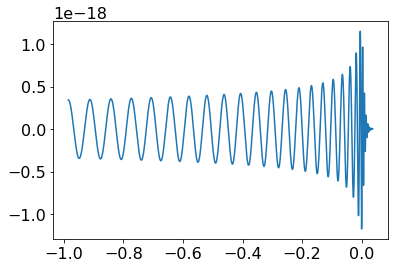

In [108]:
plt.figure()
plt.plot(uber.times_sec, uber.hplus)

In [109]:
uber_ts = pycbc.types.TimeSeries(uber.hplus, delta_t=uber.dt, epoch=uber.times_sec[0])

In [110]:
hp, hc = pycbc.waveform.get_td_waveform(approximant='SEOBNRv4', mass1=m1, mass2=m2, f_lower=14, delta_t=dt)
# hp, hc = pycbc.waveform.get_td_waveform(approximant='IMRPhenomXAS', mass1=m1, mass2=m2, f_lower=14, delta_t=dt)

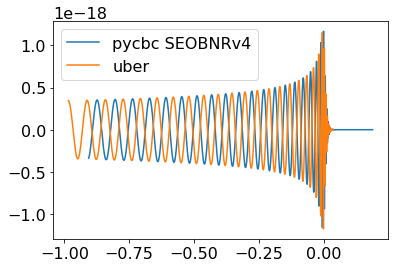

In [111]:
plt.figure()
plt.plot(hp.sample_times, hp, label='pycbc SEOBNRv4')
plt.plot(uber_ts.sample_times, uber_ts, label='uber')
plt.legend()
# plt.xlim(-0.1, 0.1)

In [112]:
h1, h2 = pycbc.waveform.utils.coalign_waveforms(hp, uber_ts)

(-1.5, 0.1)

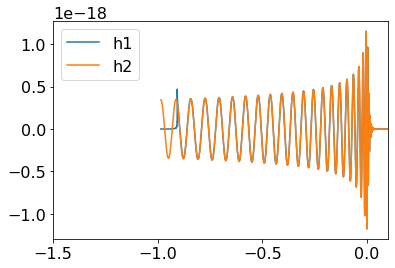

In [113]:
plt.figure()
plt.plot(h1.sample_times, h1, label='h1')
plt.plot(h2.sample_times, h2, label='h2')
plt.legend()
plt.xlim(-1.5, 0.1)
# plt.xlim(0, 0.1)

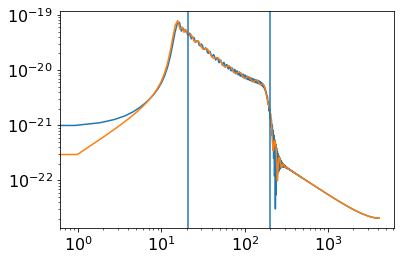

In [114]:
hp_fs = hp.to_frequencyseries()
uber_fs = uber_ts.to_frequencyseries()
plt.figure()
plt.plot(hp_fs.sample_frequencies, np.abs(hp_fs))
plt.plot(uber_fs.sample_frequencies, np.abs(uber_fs))
plt.axvline(21)
plt.axvline(200)
plt.yscale('log')
plt.xscale('log')

In [115]:
compute_match(hp, uber_ts, 20, 250)

0.9935265002664135

In [116]:
compute_match(hp, uber_ts, 20, 250, psd=False)

0.9903325261525416

In [117]:
compute_match(h1, h2, 20)

0.9928350704951009

In [118]:
compute_match(h1, h2, 20, psd=None)

0.9913995293103351

In [119]:
compute_match(h1, h2, 1)

0.9922078954138184

In [120]:
def my_match(h1, h2, times):

    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df

    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)

    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm

    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)


    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)

    return ifft / h1h1 / h2h2 * 4 * dt


In [121]:
mm = my_match(h1.numpy(), h2.numpy(), h1.sample_times.numpy())
print(np.max(np.abs(mm)))

0.9773514493976257


In [122]:
mm = my_match(hp.numpy(), uber_ts.numpy(), hp.sample_times.numpy())
print(np.max(np.abs(mm)))

0.9606002033441357
